# Representations for stable Off-Policy RL

In which I try to reproduce some of the methods and experiments in this [paper](https://arxiv.org/pdf/2007.05520.pdf) Ghosh & Bellemare.

In [1]:
from itertools import product
from collections import defaultdict
import torch
import numpy as np
from scipy.linalg import schur

np.set_printoptions(precision=2, suppress=True)

In [2]:
def transition_to_idxs(s, a, s_, a_, Na=2):
    """ Returns the (i,j) indices of a given transition in the
        P and Xi matrices.
    """
    return (s * Na + a), (s_ * Na + a_)

In [27]:
def get_Pπ(P, π=None):
    assert P.shape[1] == P.shape[2], "Not a thing."
    Na, Ns = P.shape[0], P.shape[1]
    π = torch.empty(Ns, Na).fill_(1/Na) if π is None else π
    Pπ = torch.zeros(Na * Ns, Na * Ns)
    
    for i in range(Pπ.shape[0]):
        for j in range(Pπ.shape[1]):
            s, a, s_, a_ = i // Na, i % Na, j // Na, j % Na 
            Pπ[i, j] = P[a, s, s_] * π[s_, a_]
    return Pπ

In [28]:
def get_state_distribution(P, π, s0, steps=10000):
    """ Sample the MDP with dynamics P using policy π.
    """
    Na, Ns = P.shape[0], P.shape[1]  # |A|,|S|
    Xi = torch.zeros(Na * Ns, Na * Ns)
    transitions, histogram = [], defaultdict(int)
    
    s = s0
    for step in range(steps):
        
        a = torch.multinomial(π[s], 1).item()
        s_ = torch.multinomial(P[a][s], 1).item()
    
        if transitions:
            transitions[-1][3] = a
            
        transitions.append([s, a, s_, None])
        s = s_
    
    for transition in transitions[:-1]:
        histogram[transition_to_idxs(*transition)] += 1    
    
    for k, v in sorted(histogram.items()):
        Xi[k[0]][k[0]] += v
    
    return Xi / len(transitions)

### Three-state MDP

Three states, two actions.

In [65]:
P = torch.tensor([
    [
        [0.0, 0.5, 0.5],
        [0.9, 0.1, 0.0],
        [0.3, 0.7, 0.0],
    ],
    [
        [0.1, 0.9, 0.0],
        [0.0, 0.1, 0.9],
        [0.9, 0.0, 0.1],
    ]]
)

s0 = 0

In [66]:
#π = torch.empty(P.shape[1], P.shape[0]).fill_(0.5)
π = (torch.rand(P.shape[1], P.shape[0]) * 5).softmax(1)

In [67]:
π

tensor([[0.8503, 0.1497],
        [0.5280, 0.4720],
        [0.2132, 0.7868]])

In [68]:
Pπ = get_Pπ(P, π=π)
print("\nP^π:\n", Pπ.numpy())


P^π:
 [[0.   0.   0.26 0.24 0.11 0.39]
 [0.09 0.01 0.48 0.42 0.   0.  ]
 [0.77 0.13 0.05 0.05 0.   0.  ]
 [0.   0.   0.05 0.05 0.19 0.71]
 [0.26 0.04 0.37 0.33 0.   0.  ]
 [0.77 0.13 0.   0.   0.02 0.08]]


In [69]:
Pπ = get_Pπ(P, π)
Ξ = get_state_distribution(P, π, s0, steps=100000)

print(f"ρ(Pπ)={Pπ.eig().eigenvalues[:,0].max()}\n")
print("sum(Ξ):\n", Ξ.sum().item())

print("Ξ:\n", Ξ.numpy())
print("\nP^π:\n", Pπ.numpy())

ρ(Pπ)=1.0

sum(Ξ):
 0.9999899864196777
Ξ:
 [[0.33 0.   0.   0.   0.   0.  ]
 [0.   0.06 0.   0.   0.   0.  ]
 [0.   0.   0.16 0.   0.   0.  ]
 [0.   0.   0.   0.14 0.   0.  ]
 [0.   0.   0.   0.   0.07 0.  ]
 [0.   0.   0.   0.   0.   0.25]]

P^π:
 [[0.   0.   0.26 0.24 0.11 0.39]
 [0.09 0.01 0.48 0.42 0.   0.  ]
 [0.77 0.13 0.05 0.05 0.   0.  ]
 [0.   0.   0.05 0.05 0.19 0.71]
 [0.26 0.04 0.37 0.33 0.   0.  ]
 [0.77 0.13 0.   0.   0.02 0.08]]


#### Let's get some features

In [70]:
T, Φ = schur(Pπ.numpy())
Φ = torch.from_numpy(Φ).float()

However we want $\Phi$ to be lower dimensional than $|S| \times |A|$.

Therefore we only take the $n$ basis vectors of $U$ in $A = URU^{-1}$. `numpy.schur` appears to be returning the eigenvectors of A sorted by the absolute value of their associated eigenvalues so we should be fine.

In [71]:
Φ = Φ[:, :4]
print(Φ.numpy())

[[ 0.41  0.36 -0.16 -0.82]
 [ 0.41 -0.13 -0.62  0.27]
 [ 0.41 -0.42  0.37 -0.05]
 [ 0.41  0.73  0.29  0.46]
 [ 0.41 -0.21 -0.37  0.19]
 [ 0.41 -0.33  0.48 -0.04]]


In [72]:
I = Φ.t() @ Ξ @ Φ
print("Φ^T ΞΦ should be I:\n\n", I.numpy())

Φ^T ΞΦ should be I:

 [[ 0.17  0.02  0.04 -0.08]
 [ 0.02  0.17 -0.04 -0.05]
 [ 0.04 -0.04  0.13  0.04]
 [-0.08 -0.05  0.04  0.26]]


In [73]:
def get_PI(Φ, Ξ):
    #Ξ = Ξ.clone() + torch.diag(torch.zeros(Ξ.shape[0]) + 1e-14)
    return Φ @ (Φ.t() @ Ξ @ Φ).inverse() @ Φ.t() @ Ξ

In [74]:
Π = get_PI(Φ, Ξ)
print("Π :\n", get_PI(Φ, Ξ).numpy())

Π :
 [[ 1.    0.   -0.   -0.    0.   -0.  ]
 [ 0.    0.58  0.07  0.02  0.52 -0.2 ]
 [ 0.    0.03  0.38 -0.07  0.06  0.59]
 [-0.    0.01 -0.07  0.99  0.    0.07]
 [ 0.    0.44  0.15  0.    0.41 -0.  ]
 [-0.   -0.05  0.37  0.04 -0.    0.63]]


In [75]:
(Π @ Pπ @ Π).eig().eigenvalues[:,0].max()

tensor(1.0000)

### Six-state MDP

Suppose we have this simple MDP, always starting from `S1`, with `S5` and `S6` terminal states.

<p>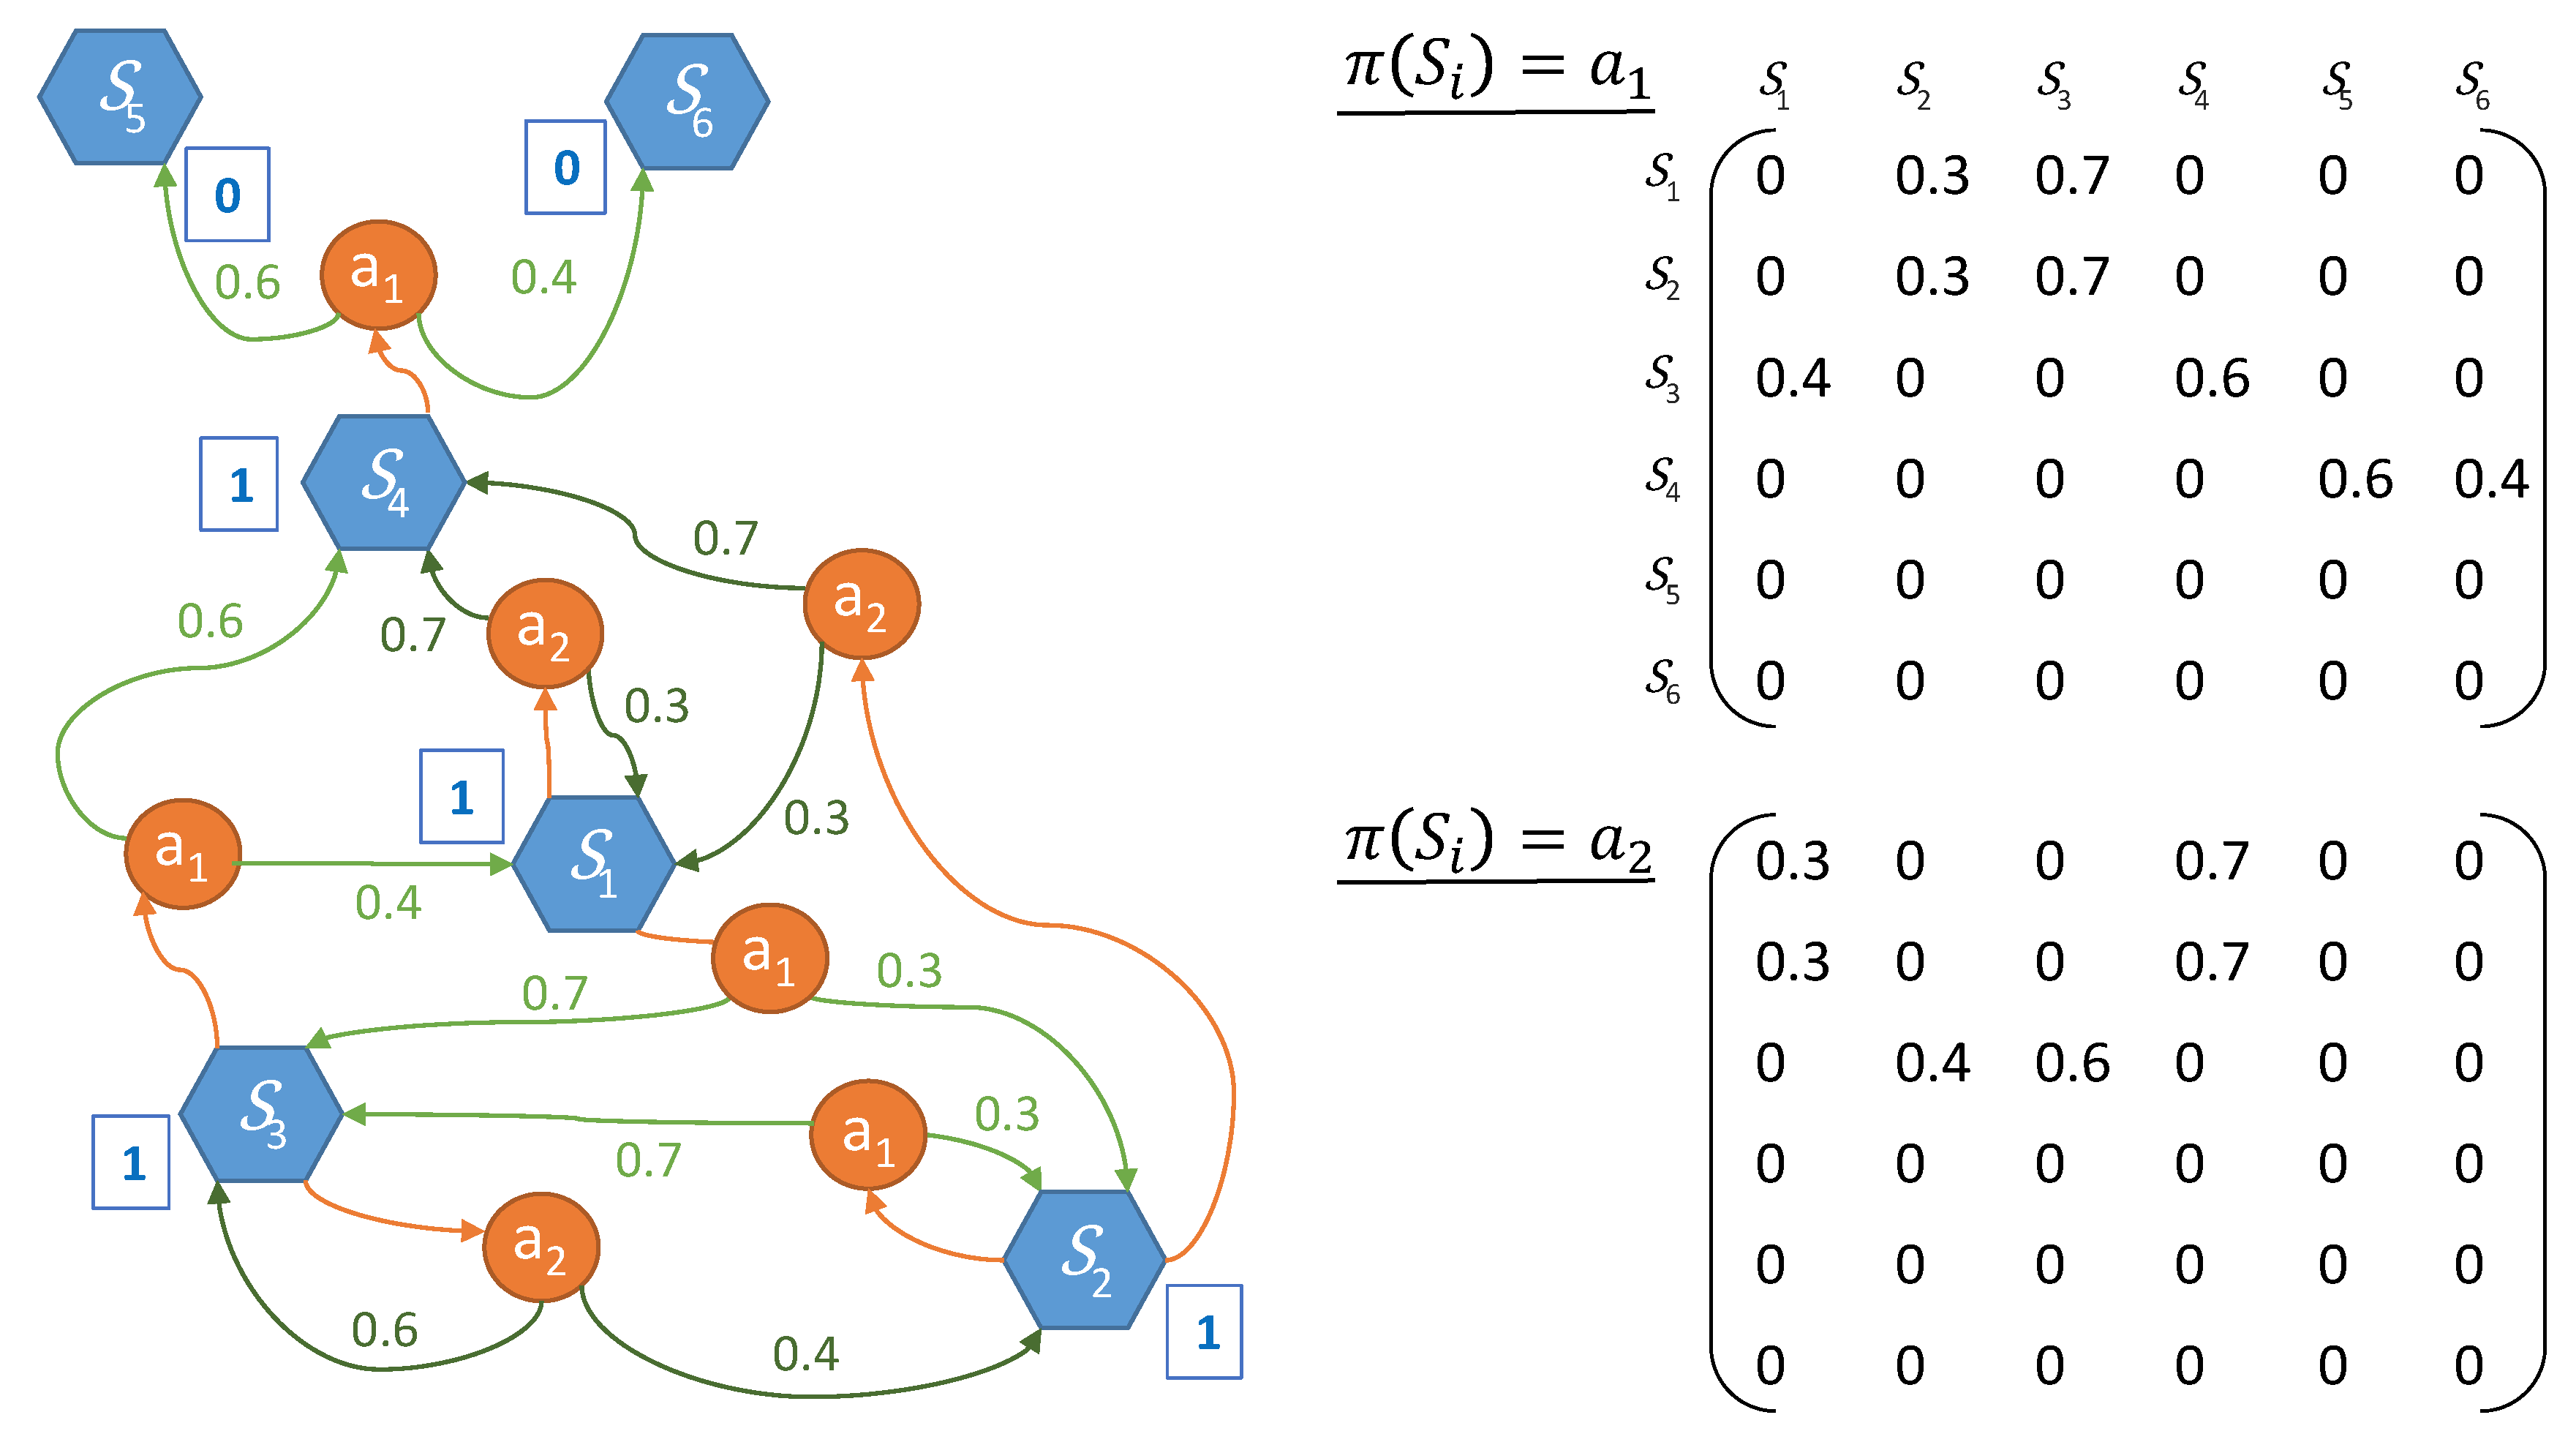</p>

In [15]:
P = torch.tensor([
    [
        [0.0, 0.3, 0.7, 0.0, 0.0, 0.0],
        [0.0, 0.3, 0.7, 0.0, 0.0, 0.0],
        [0.4, 0.0, 0.0, 0.6, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.6, 0.4],
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    ],
    [
        [0.3, 0.0, 0.0, 0.7, 0.0, 0.0],
        [0.3, 0.0, 0.0, 0.7, 0.0, 0.0],
        [0.0, 0.4, 0.6, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]])
s0 = 0    # start state
st = (4, 5)  # end states

π = torch.empty(6, 2).fill_(0.5)

print("Column sum of P(s, a0, s'): ", P[0].sum(1))
print("Column sum of P(s, a1, s'): ", P[1].sum(1))

Column sum of P(s, a0, s'):  tensor([1., 1., 1., 1., 1., 1.])
Column sum of P(s, a1, s'):  tensor([1., 1., 1., 1., 1., 1.])


---
The $\Xi$ obtained in the infinite horizon setting with "teleportation" from terminal states to the starting states.

In [16]:
Pπ = get_Pπ(P, π)
Ξ = get_state_distribution(P, π, s0, steps=100000)
print(f"ρ(Pπ)={Pπ.eig().eigenvalues[:,0].max()}\n")
print("sum(Ξ):\n", Ξ.sum().item())

print("Ξ:\n", Ξ.numpy())
print("\nP^π:\n", Pπ.numpy())

ρ(Pπ)=1.0000001192092896

sum(Ξ):
 0.9999900460243225
Ξ:
 [[0.13 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.12 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.08 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.08 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.17 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.17 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03]]

P^π:
 [[0.   0.   0.15 0.15 0.35 0.35 0.   0.   0.   0.   0.   0.  ]
 [0.15 0.15 0.   0.   0.   0.   0.35 0.35 0.   0.   0.   0.  ]
 [0.   0.   0.15 0.15 0.35 0.35 0.   0.   0.   0.   

### Schur orthogonalization

We use $P_\pi$ to get the Schur features as described in the paper at **Paragraph 4.1, Proposition 4.1**:

In [17]:
_, Φ = schur(Pπ.numpy())
Φ = torch.from_numpy(Φ).float()[:, :6]

print(Φ.numpy())

[[-0.29 -0.17 -0.12 -0.49  0.59  0.37]
 [-0.29  0.34  0.1   0.03  0.48  0.01]
 [-0.29 -0.17 -0.12 -0.49 -0.59  0.36]
 [-0.29  0.34  0.1   0.03 -0.22  0.  ]
 [-0.29  0.28  0.05  0.07 -0.05  0.01]
 [-0.29 -0.16 -0.14 -0.38  0.01 -0.85]
 [-0.29 -0.48  0.82  0.13 -0.   -0.  ]
 [-0.29  0.55  0.24 -0.08 -0.15 -0.01]
 [-0.29 -0.13 -0.23  0.3  -0.01  0.03]
 [-0.29 -0.13 -0.23  0.3  -0.01  0.03]
 [-0.29 -0.13 -0.23  0.3  -0.01  0.03]
 [-0.29 -0.13 -0.23  0.3  -0.01  0.03]]


According to **Paragraph 3.3** if $\Phi$ is orthogonal (as it should be) then $\Phi^\intercal \Xi \Phi = I$.

But for some reason it is not.

In [18]:
I = Φ.t() @ Ξ @ Φ
print("Φ^T ΞΦ should be I:\n\n", I.numpy())

Φ^T ΞΦ should be I:

 [[ 0.08 -0.01 -0.04  0.01 -0.02  0.  ]
 [-0.01  0.12 -0.03 -0.   -0.01 -0.  ]
 [-0.04 -0.03  0.13  0.02 -0.01  0.  ]
 [ 0.01 -0.    0.02  0.07 -0.02 -0.  ]
 [-0.02 -0.01 -0.01 -0.02  0.09  0.02]
 [ 0.   -0.    0.   -0.    0.02  0.08]]


## Computing $\Pi$
---

We know that $\Pi = \Phi \, (\Phi^{\intercal} \, \Xi \, \Phi)^{-1} \, \Phi^{\intercal} \, \Xi$

In [19]:
Π = get_PI(Φ, Ξ)
print("Π :\n", get_PI(Φ, Ξ).numpy())

Π :
 [[ 0.89  0.21  0.11 -0.04 -0.03  0.    0.   -0.11 -0.01 -0.01 -0.01 -0.01]
 [ 0.22  0.55 -0.22  0.02  0.11 -0.   -0.    0.24  0.02  0.03  0.02  0.02]
 [ 0.31 -0.62  0.69  0.12  0.07 -0.   -0.    0.3   0.04  0.04  0.02  0.02]
 [-0.12  0.06  0.12  0.11  0.17 -0.   -0.    0.48  0.05  0.05  0.04  0.04]
 [-0.04  0.16  0.04  0.08  0.15  0.    0.    0.34  0.08  0.08  0.05  0.05]
 [ 0.   -0.   -0.   -0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.   -0.   -0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [-0.08  0.17  0.08  0.12  0.17  0.   -0.    0.69 -0.05 -0.05 -0.03 -0.03]
 [-0.03  0.06  0.03  0.05  0.13  0.    0.   -0.16  0.27  0.28  0.18  0.19]
 [-0.03  0.06  0.03  0.05  0.13  0.    0.   -0.16  0.27  0.28  0.18  0.19]
 [-0.03  0.06  0.03  0.05  0.13  0.    0.   -0.16  0.27  0.28  0.18  0.19]
 [-0.03  0.06  0.03  0.05  0.13  0.    0.   -0.16  0.27  0.28  0.18  0.19]]


In [20]:
(Π @ Pπ @ Π).eig().eigenvalues[:,0].max()

tensor(1.0000)

Is this correlation under the Xi norm invertible?

In [21]:
#Ξ_diag = Ξ + torch.diag(torch.zeros(Ξ.shape[0]) + 1e-14)
Φ_corr = (Φ.t() @ Ξ @ Φ)

In [22]:
print("Rank of Ξ: ", torch.linalg.matrix_rank(Ξ).item())
print("Rank of Φ: ", torch.linalg.matrix_rank(Φ).item())
print("Rank of Φ_corr: ", torch.linalg.matrix_rank(Φ_corr).item())
print("\n(Φ^t Ξ Φ)^-1:\n\n", Φ_corr.inverse().numpy())

Rank of Ξ:  12
Rank of Φ:  6
Rank of Φ_corr:  6

(Φ^t Ξ Φ)^-1:

 [[15.8   2.2   5.31 -3.37  3.22 -1.  ]
 [ 2.2   8.72  2.46 -0.45  1.11 -0.29]
 [ 5.31  2.46  9.84 -3.09  1.35 -0.51]
 [-3.37 -0.45 -3.09 16.25  2.75 -0.1 ]
 [ 3.22  1.11  1.35  2.75 12.8  -2.75]
 [-1.   -0.29 -0.51 -0.1  -2.75 12.58]]


## Let's make up some features

In [23]:
import torch.nn as nn

In [24]:
net = nn.Linear(7, 12, bias=False)

In [25]:
X = torch.cat([torch.eye(6, 6).repeat_interleave(2,dim=0), torch.tensor([[0],[1]]).repeat(6,1)], dim=1)